In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import json
from datetime import datetime as dt

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (18, 10)

In [29]:
# Get stock data for BTC
def get_klines(symbol, interval, limit=500):
    url = 'https://fapi.binance.com/fapi/v1/klines'
    
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit
    }
    
    df = pd.DataFrame(json.loads(requests.get(url, params=params).text))
    df = df.iloc[:,0:6]
    df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    df['Open Time'] = [dt.fromtimestamp(x / 1000) for x in df['Open Time']]
    df['Open'] = df['Open'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)
    df['Volume'] = df['Volume'].astype(float)
    
    return df

In [30]:
data = get_klines('BTCUSDT', '1h')
data

,Open Time,Open,High,Low,Close,Volume
0,2024-01-22 05:00:00,41199.5,41221.9,40755.5,40776.7,16886.142
1,2024-01-22 06:00:00,40776.8,41153.7,40666.0,41133.6,16571.740
2,2024-01-22 07:00:00,41133.6,41334.9,41002.0,41201.3,10932.641
3,2024-01-22 08:00:00,41201.4,41210.3,40971.3,41042.6,6855.448
4,2024-01-22 09:00:00,41042.7,41044.6,40755.8,40957.3,15427.238
...,...,...,...,...,...,...
495,2024-02-11 20:00:00,48272.7,48401.1,48233.5,48282.4,4634.724
496,2024-02-11 21:00:00,48282.3,48379.9,47967.8,48020.2,9617.459
497,2024-02-11 22:00:00,48020.2,48136.1,47961.0,48118.3,5643.280
498,2024-02-11 23:00:00,48118.3,48234.2,48082.1,48140.0,4352.650


Text(0.5, 1.0, 'BTC price')

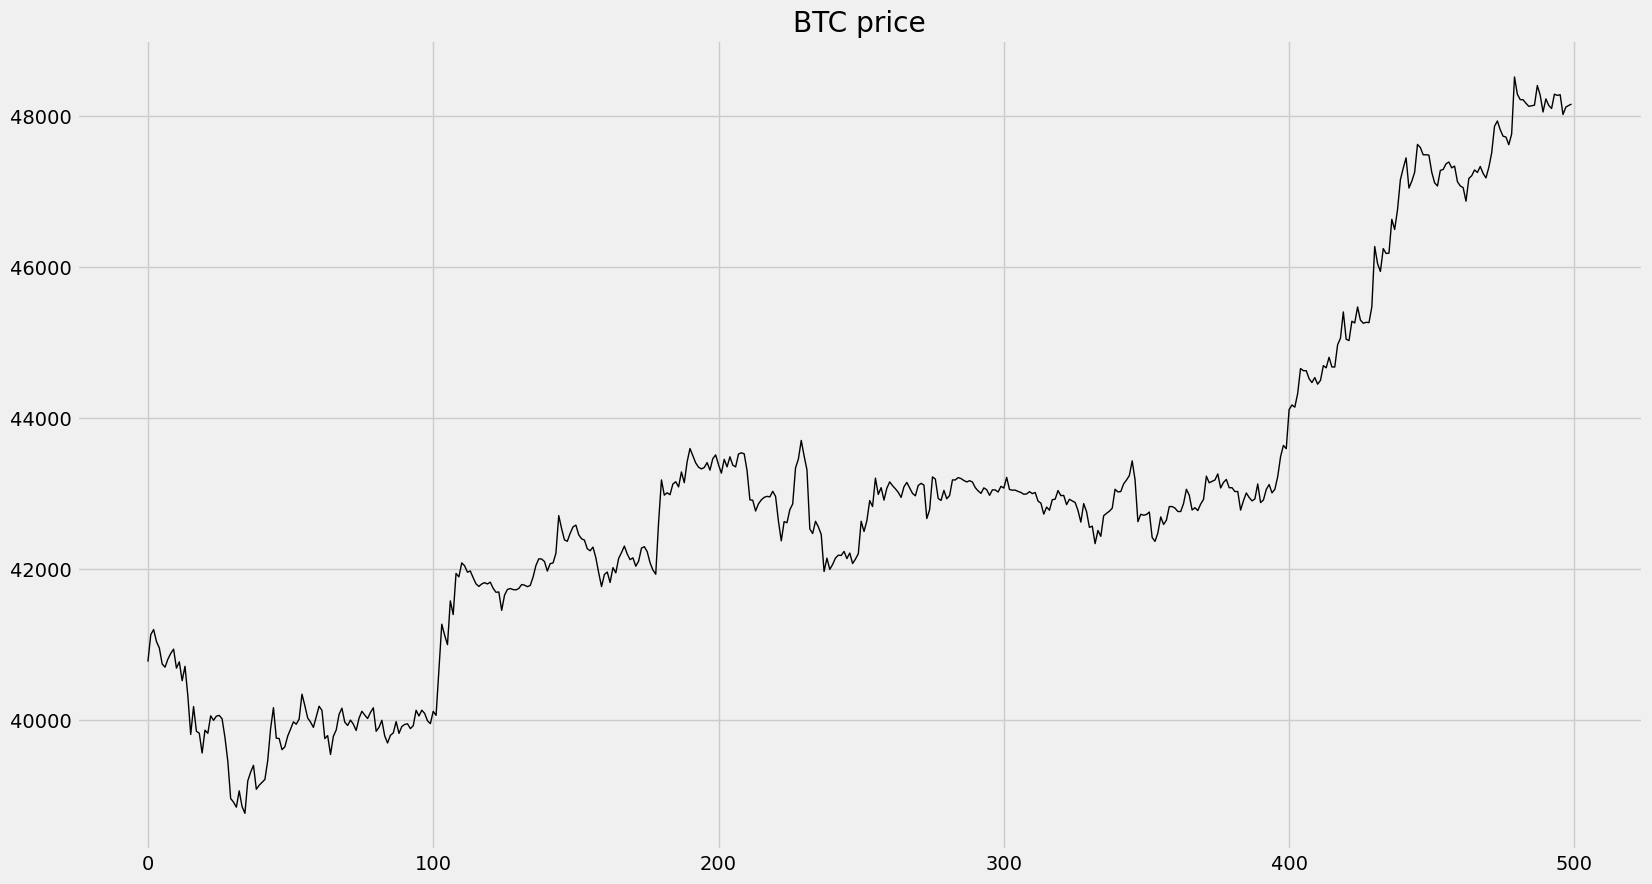

In [31]:
# Visualize the data
plt.plot(data['Close'], linewidth=1, color='black', label='Close Price')
plt.title('BTC price')

In [36]:
# Calculate the On Balance Volume (OBV)
def obv(data, period):
    OBV = []
    OBV.append(0)
    
    for i in range(len(data)):
        if i > 0:
            if data['Close'][i] > data['Close'][i-1]:
                OBV.append(OBV[-1] + data['Volume'][i])
            elif data['Close'][i] < data['Close'][i-1]:
                OBV.append(OBV[-1] - data['Volume'][i])
            else:
                OBV.append(OBV[-1])
            
    data['OBV'] = OBV
    data['OBV_EMA'] = data['OBV'].ewm(span=period).mean()
    return data

In [64]:
data = obv(data, 20)
data

,Open Time,Open,High,Low,Close,Volume,OBV,OBV_EMA
0,2024-01-22 05:00:00,41199.5,41221.9,40755.5,40776.7,16886.142,0.000,0.000000
1,2024-01-22 06:00:00,40776.8,41153.7,40666.0,41133.6,16571.740,16571.740,8700.163500
2,2024-01-22 07:00:00,41133.6,41334.9,41002.0,41201.3,10932.641,27504.381,15604.959435
3,2024-01-22 08:00:00,41201.4,41210.3,40971.3,41042.6,6855.448,20648.933,17061.076616
4,2024-01-22 09:00:00,41042.7,41044.6,40755.8,40957.3,15427.238,5221.695,14197.230954
...,...,...,...,...,...,...,...,...
495,2024-02-11 20:00:00,48272.7,48401.1,48233.5,48282.4,4634.724,177111.431,180173.872087
496,2024-02-11 21:00:00,48282.3,48379.9,47967.8,48020.2,9617.459,167493.972,178966.262555
497,2024-02-11 22:00:00,48020.2,48136.1,47961.0,48118.3,5643.280,173137.252,178411.118693
498,2024-02-11 23:00:00,48118.3,48234.2,48082.1,48140.0,4352.650,177489.902,178323.383770


In [65]:
# Create and plot the graph
def plot_obv(data):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan=3, colspan=1)
    
    ax1.plot(data['Close'], color='black', linewidth=1, label='Price')
    
    ax2.plot(data['OBV'], color='blue', linewidth=1, label='OBV')
    ax2.plot(data['OBV_EMA'], color='green', linewidth=1, label='OBV EMA')
    
    plt.title('BTC Price')
    

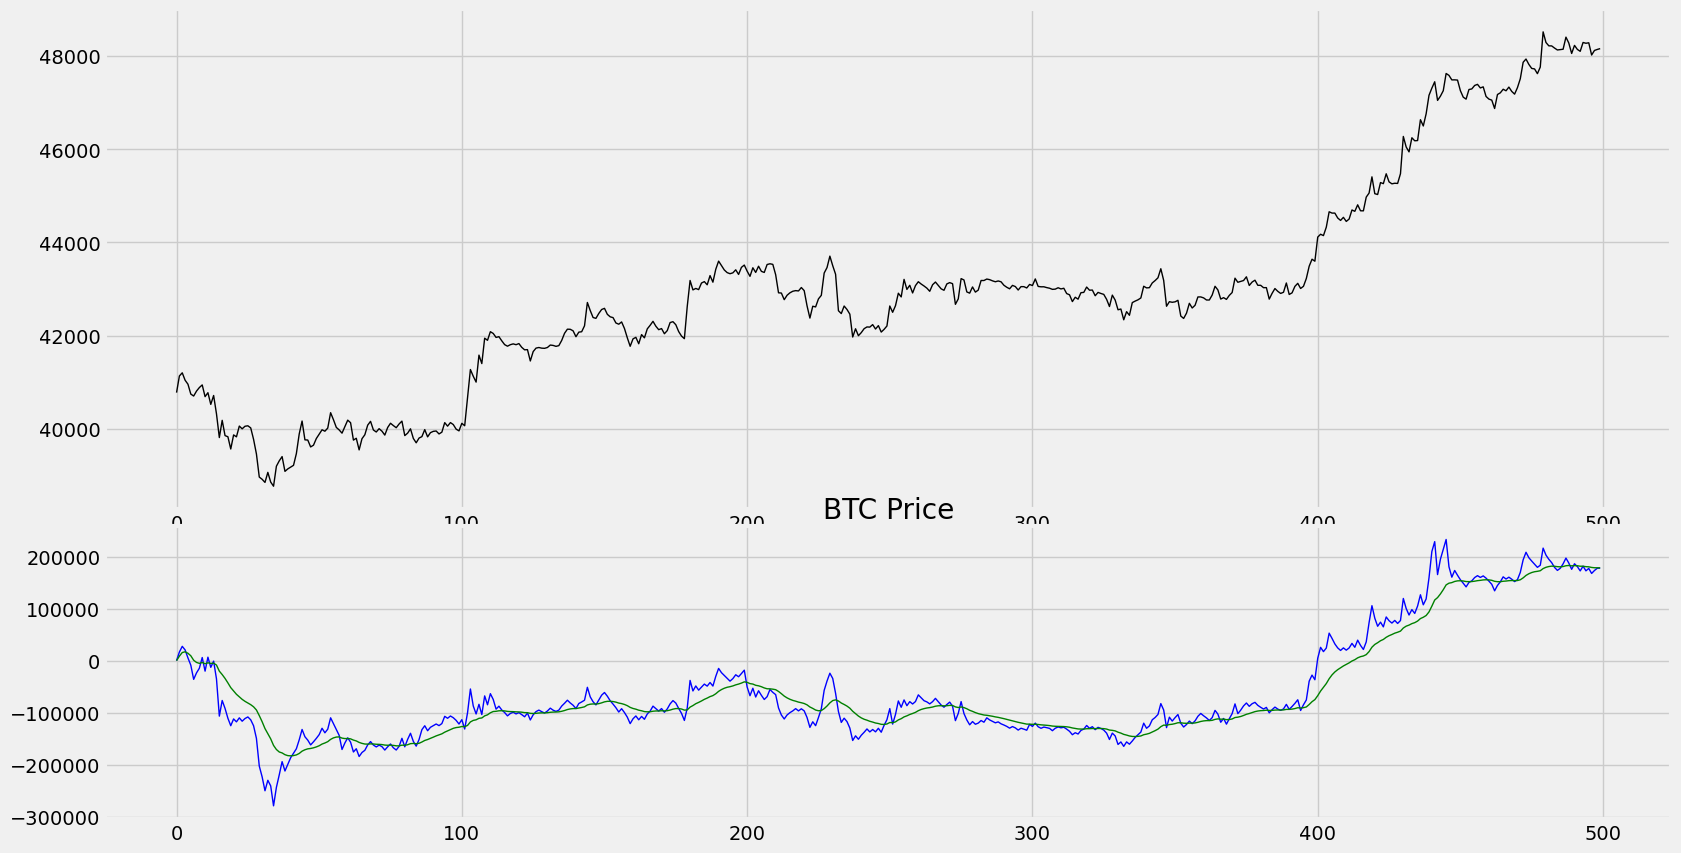

In [66]:
plot_obv(data)

In [67]:
# Implement the OBV strategy with the following logic
# if OBV > OBV_EMA = buy
# if OBV < OBV_EMA = sell
def implement_strategy(data):
    buy_price = []
    sell_price = []
    obv_signals = []
    signal = 0
    
    for i in range(len(data)):
        if data['OBV'][i] > data['OBV_EMA'][i]:
            if signal != 1:
                buy_price.append(data['Close'][i])
                sell_price.append(np.nan)
                signal = 1
                obv_signals.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                obv_signals.append(0)
        elif data['OBV'][i] < data['OBV_EMA'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data['Close'][i])
                signal = -1
                obv_signals.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                obv_signals.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            obv_signals.append(0)
            
    return buy_price, sell_price, obv_signals
            

In [68]:
buy_price, sell_price, obv_signals = implement_strategy(data)
obv_signals

[0,
 1,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 -1,
 0,
 0,
 0,
 0,
 0,
 1,
 -1,
 0,
 0,
 1,
 -1,
 1,
 0,
 0,
 -1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 -1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 1,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 -1,
 1,
 -1,
 1,
 0,
 0,
 0,
 0,
 -1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [62]:
def plot_signals(data, buy_price, sell_price):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan=3, colspan=1)
    
    ax1.plot(data['Close'], color='black', linewidth=1, label='Price')
    ax1.plot(data.index, buy_price, marker='^', color='green', markersize=10, label='Buy signal', linewidth=0)
    ax1.plot(data.index, sell_price, marker='v', color='red', markersize=10, label='Sell signal', linewidth=0)
    
    ax2.plot(data['OBV'], color='blue', linewidth=1, label='OBV')
    ax2.plot(data['OBV_EMA'], color='green', linewidth=1, label='OBV EMA')
    

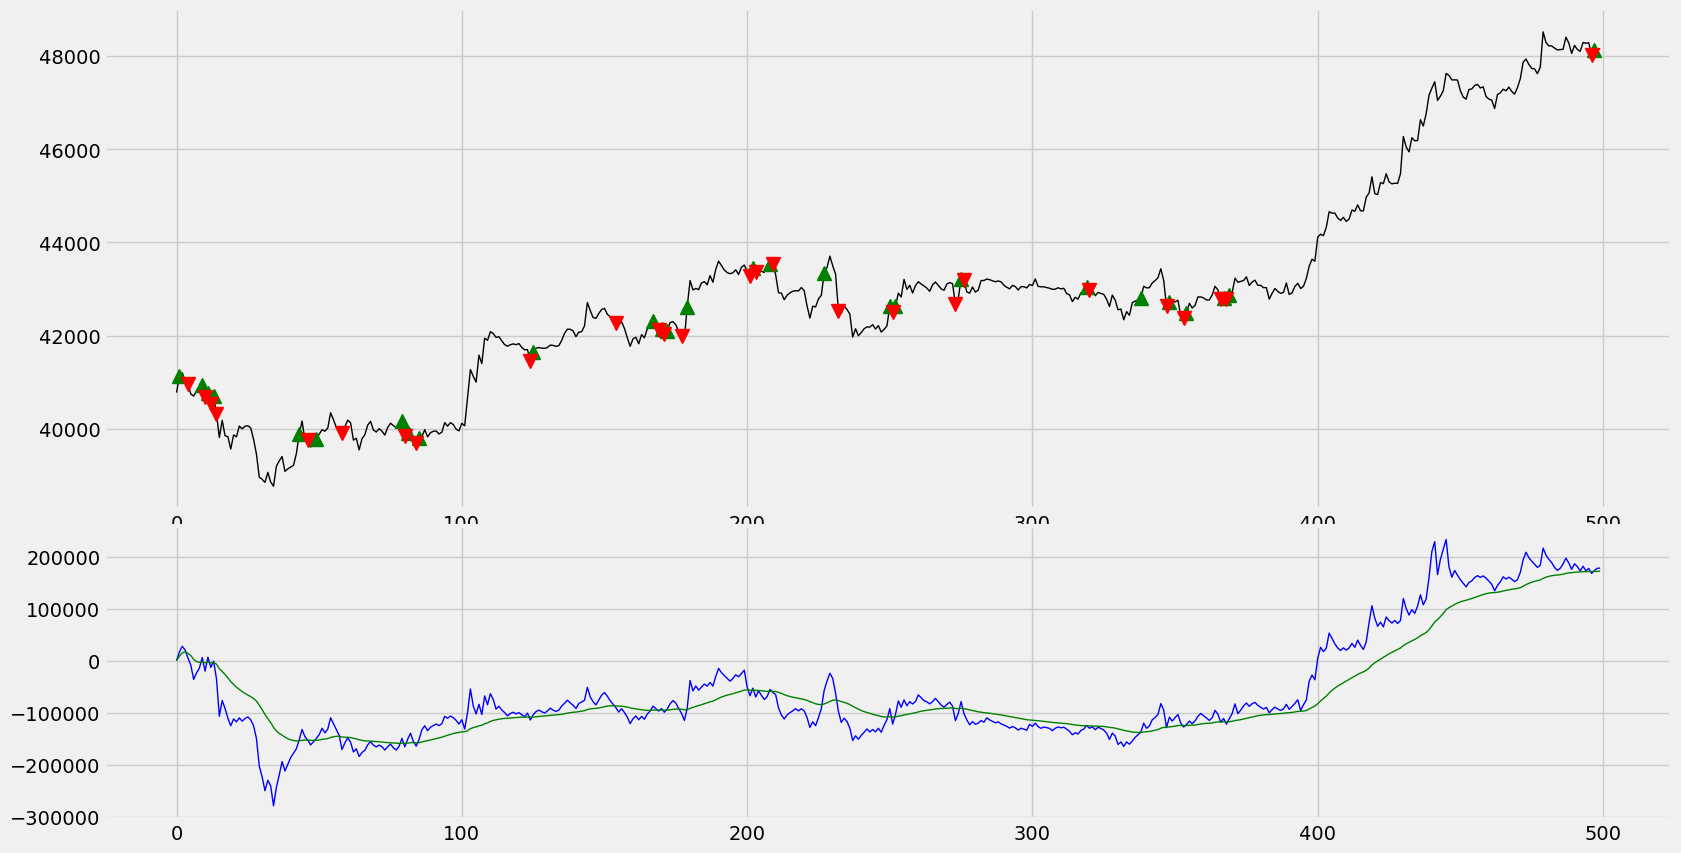

In [63]:
plot_signals(data, buy_price, sell_price)